In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn import linear_model, datasets, metrics
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [2]:
pd.set_option('display.max_columns', 100)

### [U.S. Opiate Prescriptions/Overdoses](https://www.kaggle.com/apryor6/us-opiate-prescriptions) on Kaggle has a subset of the data from [cms.gov](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Part-D-Prescriber.html): Medicare Provider Charge Data. 

#### The data decription as written on Kaggle is as follows:

- NPI – unique National Provider Identifier number
- Gender - (M/F)
- State - U.S. State by abbreviation
- Credentials - set of initials indicative of medical degree
- Specialty - description of type of medicinal practice
- A long list of drugs with numeric values indicating the total number of prescriptions written for the year by that individual
- Opioid.Prescriber - a boolean label indicating whether or not that individual prescribed opiate drugs more than 10 times in the year

#### The objective of this project is to:
- Check the prescribed medicine and see if they be useful for classfying whether a prescriber would prescribe opioids
- To built a classification model which will learn from the prescribers who prescribed opioids and non-opioid prescribtion, to predict the likelihood of a prescriber to prescribe opioids.

In [3]:
Prescriber = pd.read_csv('data/prescriber-info.csv')
Prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,0,0,0,21,0,...,0,0,0,0,0,0,0,0,0,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,15,0,...,0,0,0,0,0,25,0,0,0,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


### Data Exploration:

In [4]:
Prescriber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 256 entries, NPI to Opioid.Prescriber
dtypes: int64(252), object(4)
memory usage: 48.8+ MB


In [5]:
# The null values here are regarding the prescribed medicine
Prescriber.isnull().values.any()

True

In [6]:
# Drop the null values
Prescriber = Prescriber.dropna()

In [7]:
Prescriber.describe(include = 'all')

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.423700e+04,24237,24237,24237,24237,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.00000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.00000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,...,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000
unique,NaN,2,57,887,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,M,CA,MD,Internal Medicine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,15164,2487,7034,3102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.498151e+09,NaN,NaN,NaN,NaN,3

In [8]:
# Check how many males and females in the dataset
Prescriber['Gender'].value_counts()

M    15164
F     9073
Name: Gender, dtype: int64

### Data Cleaning:

#### Assign binary variables for 'Gender' attribute

<AxesSubplot:>

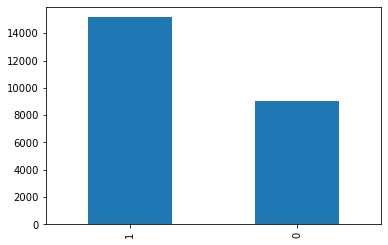

In [9]:
# creating a dict file 
gender = {'M': 1,'F': 0}
Prescriber.Gender = [gender[item] for item in Prescriber.Gender]
Prescriber['Gender'].value_counts().plot(kind='bar')

In [10]:
# Check the speciality of the prescribers
Prescriber['Specialty'].value_counts()

Internal Medicine          3102
Family Practice            2921
Dentist                    2677
Nurse Practitioner         2398
Physician Assistant        1785
                           ... 
Community Health Worker       1
Clinical Pharmacology         1
Specialist/Technologist       1
Midwife                       1
Behavioral Analyst            1
Name: Specialty, Length: 108, dtype: int64

In [11]:
# How many unique specialty? 
len(Prescriber['Specialty'].unique())

108

In [12]:
# Counting how many specialties are there by counting NPI (prescriber number) grouping by specialty
specialty = pd.DataFrame(Prescriber.groupby(['Specialty']).count()['NPI']).sort_values('NPI')

In [13]:
# I got this from Kaggle (I liked the idea of grouping the rare specialities under general one)
# Here to count how many prescribers with a specialty less than 40
specialty.loc[specialty['NPI']<40].shape

(63, 1)

#### Out of the 108 unique specialities 63 have a count of less than 40. These need to be adjusted in other or associated with a generic speciality. 

In [14]:
rareSpecialty = list(specialty.loc[specialty['NPI']<40].index)

#### Some of these rare specialities will be of the category surgery and the rest will be combined into the 'Other' category.

In [15]:
Prescriber.loc[Prescriber['Specialty'].isin(rareSpecialty),'Specialty'] = Prescriber.loc[Prescriber['Specialty'].isin(rareSpecialty),'Specialty'].apply(lambda x: 'Surgery' if 'Surgery' in list(x.split( )) else 'Other')

In [16]:
# Now we have a total of 47 in the dataset
len(Prescriber['Specialty'].unique())

47

#### NPI column is like an index column to identify the prescriber. Credentials will not be useful for model building. We do not need these to build the model. We are going to remove them.

In [17]:
Prescriber = Prescriber.drop( ['NPI','Credentials'], axis=1)

In [18]:
Prescriber.head()

,Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,...,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,AL,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,0,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0,29,51,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,36,0,31,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,1
2,0,NY,General Practice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,25,0
3,1,AZ,Internal Medicine,0,43,0,0,0,21,0,0,0,0,58,0,0,0,0,0,13,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,0,0,0,0,0,0,15,0,0,0,...,0,0,0,0,0,25,0,0,0,0,15,80,0,0,0,0,0,0,0,52,18,0,0,0,0,0,0,0,0,90,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,NV,Hematology/Oncology,0,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,28,0,0,0,1


### Data Visualization

#### We will look at 20 Top States with Opioids

In [19]:
# here to list how many states are there
Prescriber["State"].unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'FL', 'MN', 'UT', 'IA', 'IL', 'CT', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

<AxesSubplot:title={'center':'Top 20 US States where opiates are prescribed'}>

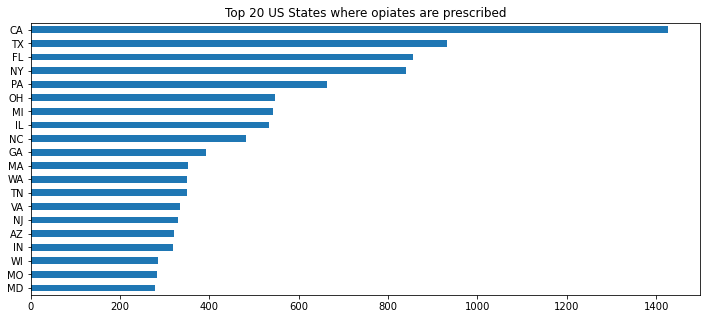

In [20]:
state_count = Prescriber["State"][Prescriber["Opioid.Prescriber"] == 1].value_counts().head(20)
state_count.sort_values(ascending=True).plot(kind="barh",
    figsize=(12,5), title="Top 20 US States where opiates are prescribed")

#### We will look at number of Specialties in the data (20 states).

<AxesSubplot:title={'center':'Top 20 number of Specialties'}>

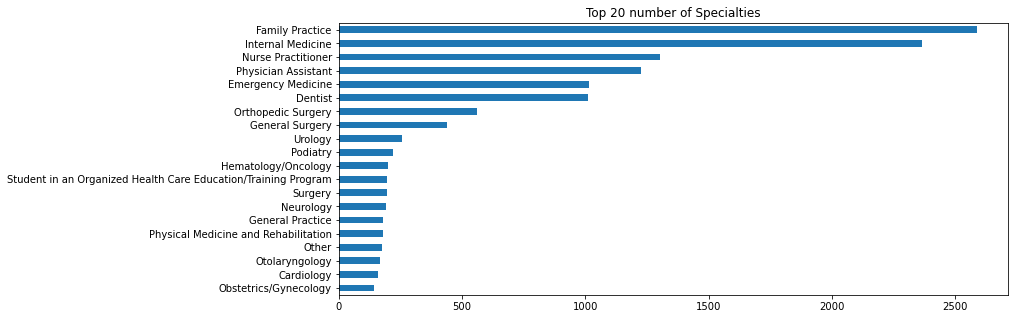

In [21]:
specialty_count = Prescriber["Specialty"][Prescriber["Opioid.Prescriber"] == 1].value_counts().head(20)
specialty_count.sort_values(ascending=True).plot(kind='barh',  figsize=(12,5), title="Top 20 number of Specialties")

In [22]:
specialty_count.sort_values(ascending=False)

Family Practice                                                   2586
Internal Medicine                                                 2364
Nurse Practitioner                                                1302
Physician Assistant                                               1226
Emergency Medicine                                                1015
Dentist                                                           1009
Orthopedic Surgery                                                 561
General Surgery                                                    437
Urology                                                            257
Podiatry                                                           219
Hematology/Oncology                                                199
Student in an Organized Health Care Education/Training Program     196
Surgery                                                            196
Neurology                                                          193
Genera

#### Finally, create dummies from the categorical data.

In [23]:
Prescriber = pd.get_dummies(Prescriber, columns=['Specialty','State'], drop_first=True)

### Building the models: 

#### We are going to use 'Opioid.Prescriber' as a target variable to predict whether or not a prescriber will prescribe a drug. 

In [24]:
# Split the dataset
X = Prescriber.drop(['Opioid.Prescriber'],axis=1).values
y = Prescriber['Opioid.Prescriber'].values

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [26]:
X_train.shape, y_train.shape

((16965, 353), (16965,))

In [27]:
X_test.shape, y_test.shape

((7272, 353), (7272,))

In [28]:
# function that generates the model, predicts test data and prints confusion matrix. 
def fit_predict_score_train(name,clf):
    clf.fit(X_train, np.ravel(y_train))
    classes = ['No Opioid', 'Opioid']
    predicted = clf.predict(X_train)
    
    # training data:
    print("Training data:")
    # Confusion matrix
    confusion_matrix =  pd.crosstab(index=np.ravel(y_train), columns=predicted.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(y_train , predicted),3)
    plt.title(name + " " + str(accuracy), fontsize = 15)
    plt.show()
    print (metrics.classification_report(y_train,predicted, target_names=classes))

In [29]:
def fit_predict_score_test(name,clf):
    clf.fit(X_train, np.ravel(y_train))
    classes = ['No Opioid', 'Opioid']
    predicted1 = clf.predict(X_test)
    # testing data
    print("Testing data:")
    # Confusion matrix
    confusion_matrix =  pd.crosstab(index=np.ravel(y_test), columns=predicted1.ravel(), rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(y_test , predicted1),3)
    plt.title(name + " " + str(accuracy), fontsize = 15)
    plt.show()
    print (metrics.classification_report(y_test,predicted1, target_names=classes))

Training data:


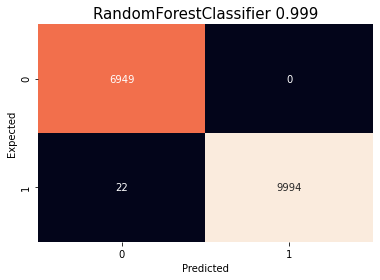

              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965



In [30]:
# We used a RandomForestClassifier first (to plot the tree later)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
name = "RandomForestClassifier"
fit_predict_score_train(name,clf)

Testing data:


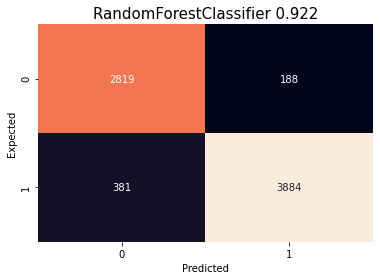

              precision    recall  f1-score   support

   No Opioid       0.88      0.94      0.91      3007
      Opioid       0.95      0.91      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.92      0.92      7272
weighted avg       0.92      0.92      0.92      7272



In [31]:
fit_predict_score_test(name,clf)

- Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.
- Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.
- F1 Score is the weighted average of Precision and Recall.  

#### RandomForestClassifier gave a promising results for classification. The accuracy is high (0.92) and the precision, recall, and f1-score are high as well.

## Visualize Random Forest
##### Interesting tree. Very imbalanced!

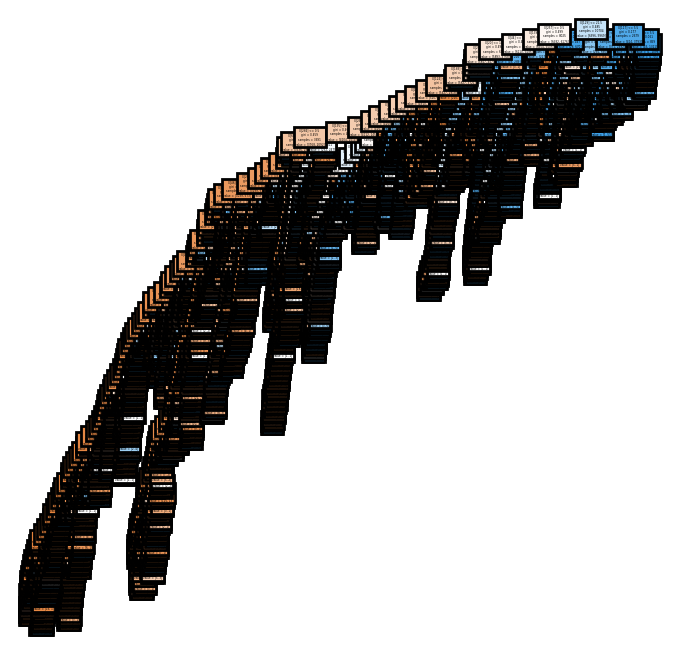

In [32]:
rf = clf

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rf.estimators_[0],
               filled = True);

# Voting Classifier 
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels.   
Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

#### Let's create 6 models, make predictions, and take the average of these predictions to come with a hard voting classifier solution. 

##### For each model,
- We are using a cross_val_score (cv=5) to get the accuracy.
- We are getting classifcation reports for the data without performing cross_val_score to compare the accuracy.

### Soft Voting:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.921 (+/- 0.004) [Logistic Regression]
Training data:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


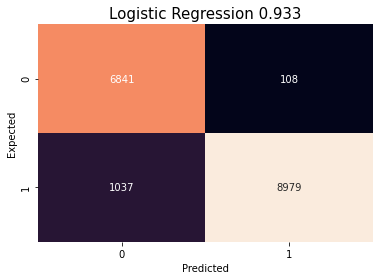

              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.99      0.90      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965

Accuracy: 0.923 (+/- 0.004) [Random Forest]
Training data:


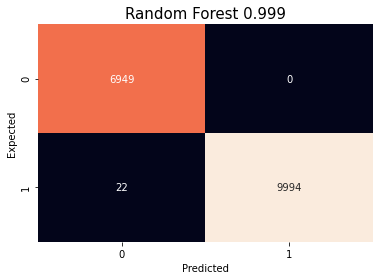

              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965

Accuracy: 0.909 (+/- 0.005) [Naive Bayes]
Training data:


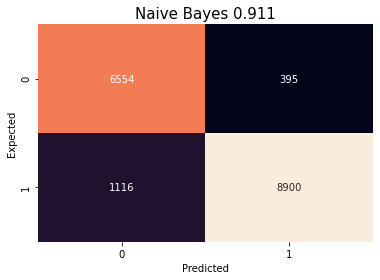

              precision    recall  f1-score   support

   No Opioid       0.85      0.94      0.90      6949
      Opioid       0.96      0.89      0.92     10016

    accuracy                           0.91     16965
   macro avg       0.91      0.92      0.91     16965
weighted avg       0.92      0.91      0.91     16965

Accuracy: 0.926 (+/- 0.005) [AdaBoost]
Training data:


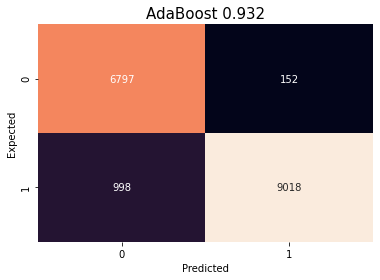

              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.98      0.90      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965

Accuracy: 0.898 (+/- 0.003) [Decision Tree]
Training data:


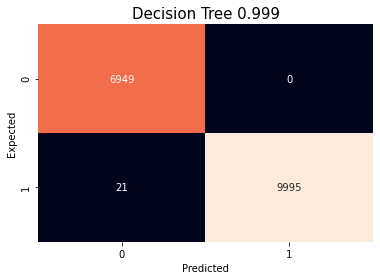

              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965

Accuracy: 0.924 (+/- 0.005) [Gradient Boosting]
Training data:


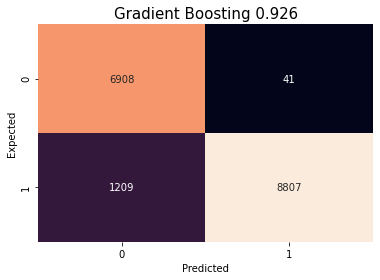

              precision    recall  f1-score   support

   No Opioid       0.85      0.99      0.92      6949
      Opioid       1.00      0.88      0.93     10016

    accuracy                           0.93     16965
   macro avg       0.92      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.926 (+/- 0.004) [Ensemble]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training data:


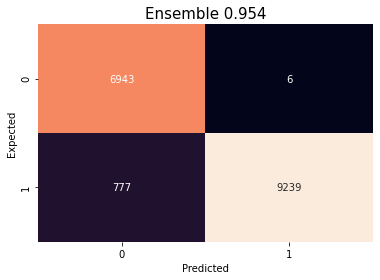

              precision    recall  f1-score   support

   No Opioid       0.90      1.00      0.95      6949
      Opioid       1.00      0.92      0.96     10016

    accuracy                           0.95     16965
   macro avg       0.95      0.96      0.95     16965
weighted avg       0.96      0.95      0.95     16965



In [33]:
clf1 = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='auto', max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf5 = DecisionTreeClassifier(random_state=0)
clf6 = GradientBoostingClassifier(random_state=0)

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('ada', clf4), ('dtree',clf5), ('gboost',clf6)],
    voting='soft')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))
    fit_predict_score_train(label,clf)

#### We are testing the Test set with all the 6 models and ensembler with soft voting

## Evaluating with the test set with the Soft Voting..

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.916 (+/- 0.005) [Logistic Regression]
Testing data:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


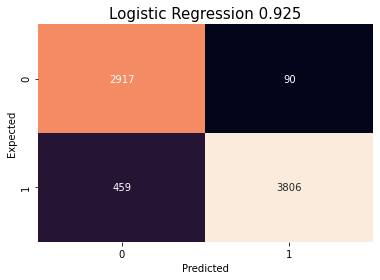

              precision    recall  f1-score   support

   No Opioid       0.86      0.97      0.91      3007
      Opioid       0.98      0.89      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.93      0.92      7272
weighted avg       0.93      0.92      0.92      7272

Accuracy: 0.921 (+/- 0.005) [Random Forest]
Testing data:


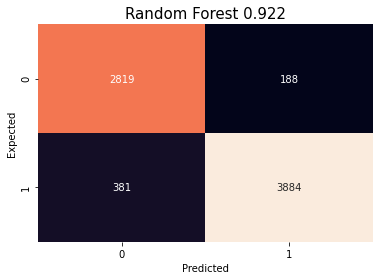

              precision    recall  f1-score   support

   No Opioid       0.88      0.94      0.91      3007
      Opioid       0.95      0.91      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.92      0.92      7272
weighted avg       0.92      0.92      0.92      7272

Accuracy: 0.908 (+/- 0.002) [Naive Bayes]
Testing data:


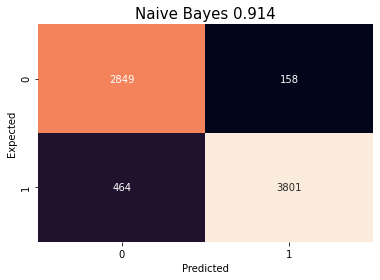

              precision    recall  f1-score   support

   No Opioid       0.86      0.95      0.90      3007
      Opioid       0.96      0.89      0.92      4265

    accuracy                           0.91      7272
   macro avg       0.91      0.92      0.91      7272
weighted avg       0.92      0.91      0.91      7272

Accuracy: 0.925 (+/- 0.003) [AdaBoost]
Testing data:


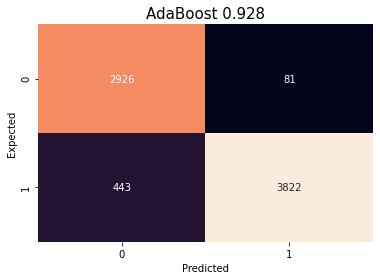

              precision    recall  f1-score   support

   No Opioid       0.87      0.97      0.92      3007
      Opioid       0.98      0.90      0.94      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.93      0.93      7272
weighted avg       0.93      0.93      0.93      7272

Accuracy: 0.899 (+/- 0.007) [Decision Tree]
Testing data:


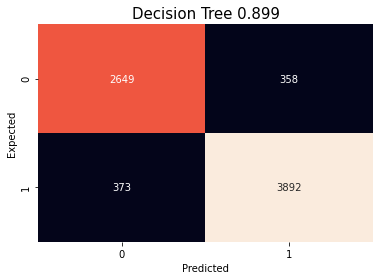

              precision    recall  f1-score   support

   No Opioid       0.88      0.88      0.88      3007
      Opioid       0.92      0.91      0.91      4265

    accuracy                           0.90      7272
   macro avg       0.90      0.90      0.90      7272
weighted avg       0.90      0.90      0.90      7272

Accuracy: 0.927 (+/- 0.004) [Gradient Boosting]
Testing data:


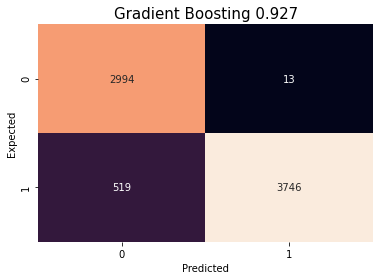

              precision    recall  f1-score   support

   No Opioid       0.85      1.00      0.92      3007
      Opioid       1.00      0.88      0.93      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.94      0.93      7272
weighted avg       0.94      0.93      0.93      7272



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.926 (+/- 0.003) [Ensemble]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing data:


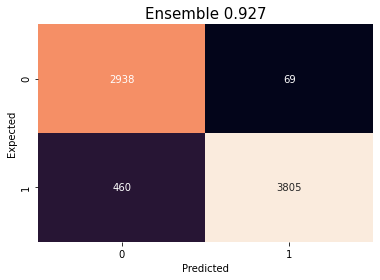

              precision    recall  f1-score   support

   No Opioid       0.86      0.98      0.92      3007
      Opioid       0.98      0.89      0.94      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.93      0.93      7272
weighted avg       0.93      0.93      0.93      7272



In [34]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    accuracy= cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (accuracy.mean(), accuracy.std(), label))
    fit_predict_score_test(label,clf)

### Hard Voting:

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.921 (+/- 0.004) [Logistic Regression]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training data:


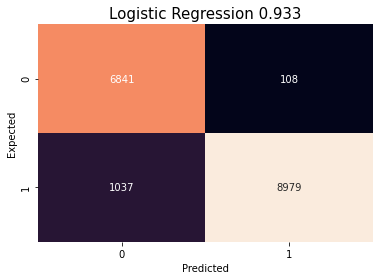

              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.99      0.90      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965

Accuracy: 0.923 (+/- 0.004) [Random Forest]
Training data:


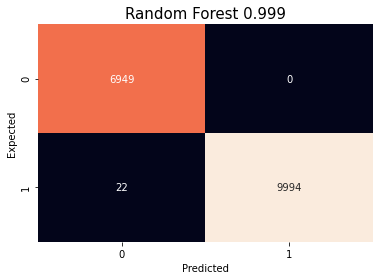

              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965

Accuracy: 0.909 (+/- 0.005) [Naive Bayes]
Training data:


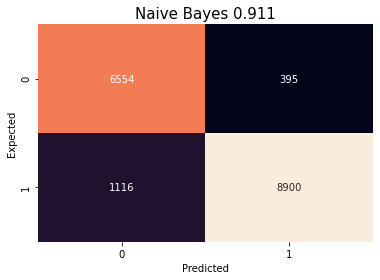

              precision    recall  f1-score   support

   No Opioid       0.85      0.94      0.90      6949
      Opioid       0.96      0.89      0.92     10016

    accuracy                           0.91     16965
   macro avg       0.91      0.92      0.91     16965
weighted avg       0.92      0.91      0.91     16965

Accuracy: 0.926 (+/- 0.005) [AdaBoost]
Training data:


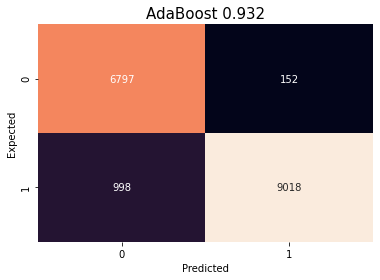

              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.98      0.90      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965

Accuracy: 0.898 (+/- 0.003) [Decision Tree]
Training data:


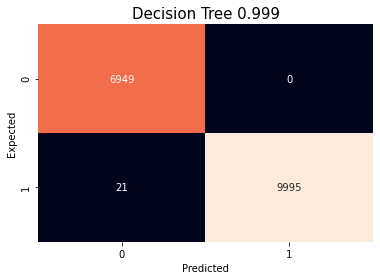

              precision    recall  f1-score   support

   No Opioid       1.00      1.00      1.00      6949
      Opioid       1.00      1.00      1.00     10016

    accuracy                           1.00     16965
   macro avg       1.00      1.00      1.00     16965
weighted avg       1.00      1.00      1.00     16965

Accuracy: 0.927 (+/- 0.005) [Gradient Boosting]
Training data:


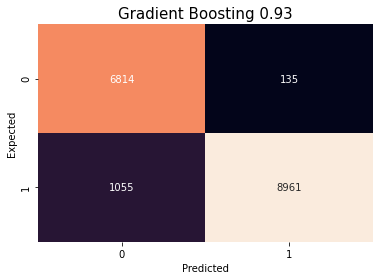

              precision    recall  f1-score   support

   No Opioid       0.87      0.98      0.92      6949
      Opioid       0.99      0.89      0.94     10016

    accuracy                           0.93     16965
   macro avg       0.93      0.94      0.93     16965
weighted avg       0.94      0.93      0.93     16965



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.928 (+/- 0.003) [Ensemble]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training data:


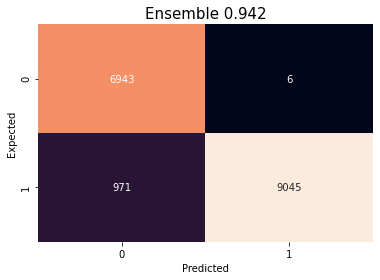

              precision    recall  f1-score   support

   No Opioid       0.88      1.00      0.93      6949
      Opioid       1.00      0.90      0.95     10016

    accuracy                           0.94     16965
   macro avg       0.94      0.95      0.94     16965
weighted avg       0.95      0.94      0.94     16965



In [35]:
clf1 = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='auto', max_iter=1000)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf5 = DecisionTreeClassifier(random_state=0)
clf6 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('ada', clf4), ('dtree',clf5), ('gboost',clf6)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))
    fit_predict_score_train(label,clf)

#### We can see that the ensembled model with all the 6 models performed the same with soft and hard voting. All the models have high accuracy scores. I will further use the test set with the Hard Voting to compare the performances between the models.

## Evaluating with the test set with the Hard Voting..

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.916 (+/- 0.005) [Logistic Regression]
Testing data:


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


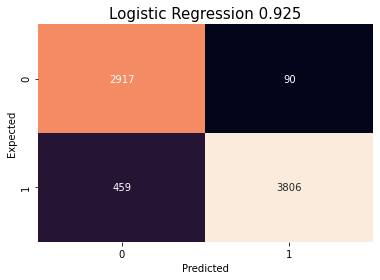

              precision    recall  f1-score   support

   No Opioid       0.86      0.97      0.91      3007
      Opioid       0.98      0.89      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.93      0.92      7272
weighted avg       0.93      0.92      0.92      7272

Accuracy: 0.921 (+/- 0.005) [Random Forest]
Testing data:


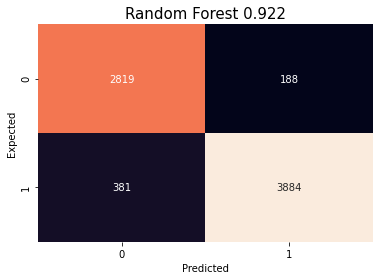

              precision    recall  f1-score   support

   No Opioid       0.88      0.94      0.91      3007
      Opioid       0.95      0.91      0.93      4265

    accuracy                           0.92      7272
   macro avg       0.92      0.92      0.92      7272
weighted avg       0.92      0.92      0.92      7272

Accuracy: 0.908 (+/- 0.002) [Naive Bayes]
Testing data:


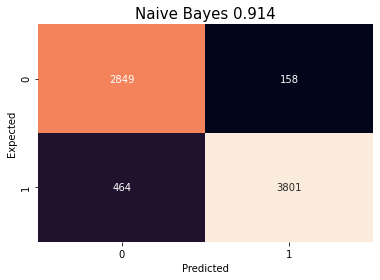

              precision    recall  f1-score   support

   No Opioid       0.86      0.95      0.90      3007
      Opioid       0.96      0.89      0.92      4265

    accuracy                           0.91      7272
   macro avg       0.91      0.92      0.91      7272
weighted avg       0.92      0.91      0.91      7272

Accuracy: 0.925 (+/- 0.003) [AdaBoost]
Testing data:


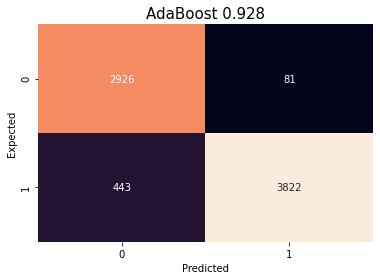

              precision    recall  f1-score   support

   No Opioid       0.87      0.97      0.92      3007
      Opioid       0.98      0.90      0.94      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.93      0.93      7272
weighted avg       0.93      0.93      0.93      7272

Accuracy: 0.899 (+/- 0.007) [Decision Tree]
Testing data:


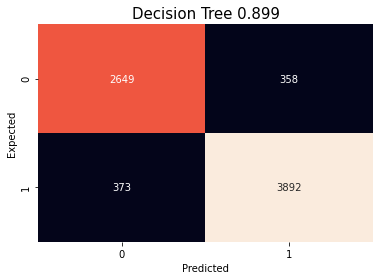

              precision    recall  f1-score   support

   No Opioid       0.88      0.88      0.88      3007
      Opioid       0.92      0.91      0.91      4265

    accuracy                           0.90      7272
   macro avg       0.90      0.90      0.90      7272
weighted avg       0.90      0.90      0.90      7272

Accuracy: 0.924 (+/- 0.004) [Gradient Boosting]
Testing data:


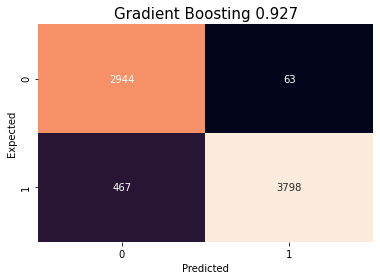

              precision    recall  f1-score   support

   No Opioid       0.86      0.98      0.92      3007
      Opioid       0.98      0.89      0.93      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.93      0.93      7272
weighted avg       0.93      0.93      0.93      7272



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.928 (+/- 0.003) [Ensemble]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing data:


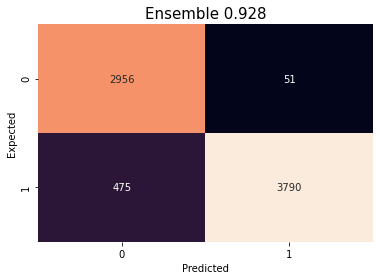

              precision    recall  f1-score   support

   No Opioid       0.86      0.98      0.92      3007
      Opioid       0.99      0.89      0.94      4265

    accuracy                           0.93      7272
   macro avg       0.92      0.94      0.93      7272
weighted avg       0.93      0.93      0.93      7272



In [36]:
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'AdaBoost', 'Decision Tree', 'Gradient Boosting', 'Ensemble']):
    accuracy= cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5)
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (accuracy.mean(), accuracy.std(), label))
    fit_predict_score_test(label,clf)

#### All the 6 models and the ensembled models with soft and hard voting performed well and the accuracies were very close. All the models have high accuracy scores [90%-93%]  on the testing data. That means, the models we built to predict and classify whether or not the prescriber will prescribe an opioid are working with above 90% accuracy score. 